### Основное задание
####    Возьмите датасет https://www.kaggle.com/ajayrana/hymenoptera-data/kernels
1. Обучите на нем модели ResNet 18 и VGG 16 с нуля (5-10 эпох)
2. Обучите на нем модели ResNet 18 и VGG 16 с использованием FineTuning (5-10 эпох) 
3. Добавьте аугментацию данных к пункту 2
#### Сравните качество всех 3 полученных подходов
#### Задание со звездочкой
##### Примените FineTuning ResNet 18 к FashionMnist. Удалось ли увидеть резкое увеличение качества?

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
from albumentations.pytorch import ToTensor
import albumentations as A
from PIL import Image
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
import torchvision as tv

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0


In [3]:
train_dir='hymenoptera_data/train'
train_files = sorted(list(Path(train_dir).rglob('*.jpg')))
val_dir='hymenoptera_data/val'
val_files = sorted(list(Path(val_dir).rglob('*.jpg')))

In [4]:
augmentation_pipeline = transforms.RandomOrder([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomRotation(degrees=10)], p=0.25),
    transforms.RandomApply([transforms.RandomAffine((-10,10), (0.1,0.1))], p=0.25),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.25),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.02,contrast=0.02,saturation=0.02,hue=(-0.02, 0.02))], p=0.01)
    ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


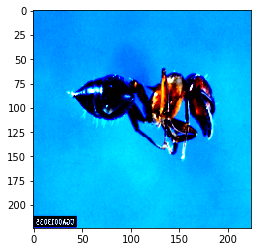

In [5]:
class myDataset(Dataset):
    def __init__(self, files, augmentations = None):
        self.files = files
        self.augmentations = augmentations
        self.len_ = len(self.files)
        self.labels = [path.parent.name for path in self.files]
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    def __len__(self):
        return self.len_
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.Resize((224,224)),
                  transforms.ToTensor(),
                  
                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                
                ])
        x = self.load_sample(self.files[index]) 
        if self.augmentations:
            x=self.augmentations(x)
        x = transform(x)    
        label = 1 if self.labels[index]=='ants' else 0  
            
        return x,label

    
train_dataset = myDataset(train_files,augmentations = augmentation_pipeline )

for x,y in train_dataset:

    print(y)
    plt.imshow(x.numpy().transpose(1, 2, 0))

    break

In [6]:
def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    for X, y in data_iter:
        X, y = X.cuda(), y.cuda()
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [7]:
def train(net, train_iter, test_iter, trainer, num_epochs, dev):
    loss = nn.CrossEntropyLoss()
    net.cuda()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        net.train()
        for X, y in train_iter:
            
            trainer.zero_grad()
            X, y = X.cuda(), y.cuda()  
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        net.eval()
        test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))
        


In [8]:
train_dataset = myDataset(train_files)
val_dataset = myDataset(val_files)


In [9]:
train_loader = DataLoader(train_dataset, shuffle=1, batch_size=32)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=32)

### 1. Обучите на нем модели ResNet 18 и VGG 16 с нуля (5-10 эпох)

In [10]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [11]:
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(in_features=512, out_features=2)

In [12]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [37]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_loader, val_loader, trainer, num_epochs, dev)

epoch 1, loss 0.0232, train acc 0.510, test acc 0.654, time 2.7 sec
epoch 2, loss 0.0209, train acc 0.654, test acc 0.549, time 2.7 sec
epoch 3, loss 0.0194, train acc 0.683, test acc 0.582, time 2.6 sec
epoch 4, loss 0.0184, train acc 0.687, test acc 0.654, time 2.6 sec
epoch 5, loss 0.0180, train acc 0.745, test acc 0.647, time 2.6 sec
epoch 6, loss 0.0179, train acc 0.712, test acc 0.667, time 2.6 sec
epoch 7, loss 0.0170, train acc 0.741, test acc 0.712, time 2.6 sec
epoch 8, loss 0.0158, train acc 0.786, test acc 0.745, time 2.6 sec
epoch 9, loss 0.0158, train acc 0.782, test acc 0.712, time 2.6 sec
epoch 10, loss 0.0157, train acc 0.765, test acc 0.745, time 2.6 sec


In [27]:
model = models.vgg16(pretrained=False)
model.classifier[-1]=nn.Linear(in_features=4096, out_features=2)
#model.fc = nn.Linear(in_features=512, out_features=2)

In [28]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_loader, val_loader, trainer, num_epochs, dev)

epoch 1, loss 0.0228, train acc 0.519, test acc 0.542, time 4.6 sec
epoch 2, loss 0.0229, train acc 0.523, test acc 0.542, time 4.5 sec
epoch 3, loss 0.0230, train acc 0.477, test acc 0.471, time 4.5 sec
epoch 4, loss 0.0230, train acc 0.424, test acc 0.510, time 4.5 sec
epoch 5, loss 0.0228, train acc 0.527, test acc 0.542, time 4.5 sec
epoch 6, loss 0.0227, train acc 0.523, test acc 0.569, time 4.5 sec
epoch 7, loss 0.0227, train acc 0.535, test acc 0.634, time 4.5 sec
epoch 8, loss 0.0226, train acc 0.551, test acc 0.614, time 4.5 sec
epoch 9, loss 0.0224, train acc 0.609, test acc 0.634, time 4.6 sec
epoch 10, loss 0.0224, train acc 0.617, test acc 0.634, time 4.5 sec


* vgg16 сложнее и учится медленнее

### 2. Обучите на нем модели ResNet 18 и VGG 16 с использованием FineTuning (5-10 эпох) 

#### ResNet 18

##### обучим только один линейный слой

In [20]:
model = models.resnet18(pretrained=1)

In [21]:
## Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [22]:
model.fc = nn.Linear(in_features=512, out_features=2)

In [23]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_loader, val_loader, trainer, num_epochs, dev)

epoch 1, loss 0.0217, train acc 0.564, test acc 0.784, time 2.3 sec
epoch 2, loss 0.0167, train acc 0.774, test acc 0.843, time 2.4 sec
epoch 3, loss 0.0120, train acc 0.872, test acc 0.876, time 2.4 sec
epoch 4, loss 0.0098, train acc 0.901, test acc 0.882, time 2.5 sec
epoch 5, loss 0.0086, train acc 0.918, test acc 0.889, time 2.5 sec
epoch 6, loss 0.0068, train acc 0.934, test acc 0.876, time 2.4 sec
epoch 7, loss 0.0063, train acc 0.951, test acc 0.895, time 2.5 sec
epoch 8, loss 0.0071, train acc 0.934, test acc 0.902, time 2.4 sec
epoch 9, loss 0.0057, train acc 0.955, test acc 0.882, time 2.7 sec
epoch 10, loss 0.0051, train acc 0.963, test acc 0.902, time 2.4 sec


#### Дообучим все слои

In [ ]:
for param in model.parameters():
    param.requires_grad = True

In [26]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_loader, val_loader, trainer, num_epochs, dev)

epoch 1, loss 0.0048, train acc 0.971, test acc 0.915, time 2.7 sec
epoch 2, loss 0.0040, train acc 0.975, test acc 0.941, time 2.7 sec
epoch 3, loss 0.0028, train acc 0.992, test acc 0.948, time 2.7 sec
epoch 4, loss 0.0022, train acc 1.000, test acc 0.895, time 2.7 sec
epoch 5, loss 0.0017, train acc 1.000, test acc 0.941, time 2.7 sec
epoch 6, loss 0.0016, train acc 0.996, test acc 0.941, time 2.7 sec
epoch 7, loss 0.0010, train acc 1.000, test acc 0.948, time 2.7 sec
epoch 8, loss 0.0008, train acc 1.000, test acc 0.935, time 2.6 sec
epoch 9, loss 0.0007, train acc 1.000, test acc 0.908, time 2.7 sec
epoch 10, loss 0.0008, train acc 1.000, test acc 0.941, time 2.7 sec


#### C Самого начала будем обучать всю сеть

In [27]:
model = models.resnet18(pretrained=1)
model.fc = nn.Linear(in_features=512, out_features=2)

In [28]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_loader, val_loader, trainer, num_epochs, dev)

epoch 1, loss 0.0236, train acc 0.551, test acc 0.765, time 2.7 sec
epoch 2, loss 0.0138, train acc 0.848, test acc 0.869, time 2.6 sec
epoch 3, loss 0.0075, train acc 0.947, test acc 0.908, time 2.7 sec
epoch 4, loss 0.0051, train acc 0.975, test acc 0.908, time 2.7 sec
epoch 5, loss 0.0036, train acc 0.979, test acc 0.922, time 2.6 sec
epoch 6, loss 0.0023, train acc 0.996, test acc 0.922, time 2.7 sec
epoch 7, loss 0.0018, train acc 0.992, test acc 0.915, time 2.6 sec
epoch 8, loss 0.0013, train acc 1.000, test acc 0.922, time 2.7 sec
epoch 9, loss 0.0010, train acc 1.000, test acc 0.922, time 2.7 sec
epoch 10, loss 0.0011, train acc 1.000, test acc 0.922, time 2.6 sec


In [29]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_loader, val_loader, trainer, num_epochs, dev)

epoch 1, loss 0.0008, train acc 1.000, test acc 0.922, time 2.6 sec
epoch 2, loss 0.0007, train acc 1.000, test acc 0.922, time 2.6 sec
epoch 3, loss 0.0007, train acc 1.000, test acc 0.915, time 2.6 sec
epoch 4, loss 0.0006, train acc 1.000, test acc 0.928, time 2.7 sec
epoch 5, loss 0.0005, train acc 1.000, test acc 0.928, time 2.7 sec
epoch 6, loss 0.0006, train acc 1.000, test acc 0.915, time 2.6 sec
epoch 7, loss 0.0005, train acc 1.000, test acc 0.922, time 2.7 sec
epoch 8, loss 0.0006, train acc 1.000, test acc 0.922, time 2.6 sec
epoch 9, loss 0.0006, train acc 1.000, test acc 0.922, time 2.7 sec
epoch 10, loss 0.0004, train acc 1.000, test acc 0.915, time 2.6 sec


* подход с поэтапным обучением (сначала классификатор, потом всю сеть, вроде как, лучше работает) мы нашли лучший минимум

#### VGG 16 

##### обучим только один линейный слой

In [17]:
model = models.vgg16(pretrained=1)
for param in model.parameters():
    param.requires_grad = False
model.classifier[-1]=nn.Linear(in_features=4096, out_features=2)

In [18]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_loader, val_loader, trainer, num_epochs, dev)

epoch 1, loss 0.0167, train acc 0.728, test acc 0.941, time 2.9 sec
epoch 2, loss 0.0052, train acc 0.942, test acc 0.948, time 2.8 sec
epoch 3, loss 0.0038, train acc 0.951, test acc 0.941, time 2.9 sec
epoch 4, loss 0.0031, train acc 0.971, test acc 0.935, time 2.9 sec
epoch 5, loss 0.0025, train acc 0.975, test acc 0.935, time 2.9 sec
epoch 6, loss 0.0023, train acc 0.975, test acc 0.935, time 2.9 sec
epoch 7, loss 0.0018, train acc 0.984, test acc 0.935, time 2.9 sec
epoch 8, loss 0.0017, train acc 0.988, test acc 0.941, time 3.0 sec
epoch 9, loss 0.0017, train acc 0.984, test acc 0.941, time 3.1 sec
epoch 10, loss 0.0018, train acc 0.984, test acc 0.941, time 3.0 sec


#### C Самого начала будем обучать всю сеть

In [33]:
model = models.vgg16(pretrained=1)
model.classifier[-1]=nn.Linear(in_features=4096, out_features=2)


In [34]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_loader, val_loader, trainer, num_epochs, dev)

epoch 1, loss 0.0151, train acc 0.778, test acc 0.954, time 4.5 sec
epoch 2, loss 0.0037, train acc 0.947, test acc 0.948, time 4.5 sec
epoch 3, loss 0.0015, train acc 0.979, test acc 0.948, time 4.5 sec
epoch 4, loss 0.0006, train acc 0.996, test acc 0.948, time 4.5 sec
epoch 5, loss 0.0003, train acc 1.000, test acc 0.948, time 4.5 sec
epoch 6, loss 0.0005, train acc 0.996, test acc 0.948, time 4.5 sec
epoch 7, loss 0.0001, train acc 1.000, test acc 0.935, time 4.6 sec
epoch 8, loss 0.0001, train acc 1.000, test acc 0.935, time 4.5 sec
epoch 9, loss 0.0001, train acc 1.000, test acc 0.941, time 4.5 sec
epoch 10, loss 0.0000, train acc 1.000, test acc 0.941, time 4.5 sec


* Результаты  с finetuning значительно улучшились
* обучаемся гораздо быстрее


###  3. Добавьте аугментацию данных к пункту 2

#### RESNET

In [37]:
train_dataset = myDataset(train_files,augmentations=augmentation_pipeline)
val_dataset = myDataset(val_files)


In [38]:
train_loader = DataLoader(train_dataset, shuffle=1, batch_size=32)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=32)

In [39]:
model = models.resnet18(pretrained=1)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(in_features=512, out_features=2)

In [40]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_loader, val_loader, trainer, num_epochs, dev)

epoch 1, loss 0.0208, train acc 0.658, test acc 0.647, time 3.2 sec
epoch 2, loss 0.0157, train acc 0.790, test acc 0.876, time 3.4 sec
epoch 3, loss 0.0121, train acc 0.881, test acc 0.876, time 3.7 sec
epoch 4, loss 0.0098, train acc 0.901, test acc 0.902, time 3.7 sec
epoch 5, loss 0.0089, train acc 0.930, test acc 0.895, time 3.3 sec
epoch 6, loss 0.0076, train acc 0.934, test acc 0.882, time 3.4 sec
epoch 7, loss 0.0071, train acc 0.922, test acc 0.915, time 3.4 sec
epoch 8, loss 0.0072, train acc 0.947, test acc 0.915, time 3.4 sec
epoch 9, loss 0.0080, train acc 0.926, test acc 0.928, time 3.5 sec
epoch 10, loss 0.0064, train acc 0.926, test acc 0.889, time 3.6 sec


In [41]:
#разморозим сверточные слое
for param in model.parameters():
    param.requires_grad = True

In [42]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_loader, val_loader, trainer, num_epochs, dev)

epoch 1, loss 0.0060, train acc 0.947, test acc 0.928, time 3.8 sec
epoch 2, loss 0.0050, train acc 0.951, test acc 0.928, time 3.8 sec
epoch 3, loss 0.0044, train acc 0.971, test acc 0.935, time 3.8 sec
epoch 4, loss 0.0044, train acc 0.959, test acc 0.954, time 4.3 sec
epoch 5, loss 0.0031, train acc 0.988, test acc 0.948, time 3.8 sec
epoch 6, loss 0.0021, train acc 0.992, test acc 0.941, time 3.8 sec
epoch 7, loss 0.0018, train acc 0.996, test acc 0.928, time 3.8 sec
epoch 8, loss 0.0019, train acc 0.996, test acc 0.928, time 3.5 sec
epoch 9, loss 0.0011, train acc 1.000, test acc 0.941, time 3.6 sec
epoch 10, loss 0.0017, train acc 0.996, test acc 0.928, time 3.6 sec


* на аугментированных картинках, мы получаем большую тестовую точность
* медленнее переобучаемся

#### VGG 16 

In [43]:
model = models.vgg16(pretrained=1)
for param in model.parameters():
    param.requires_grad = False
model.classifier[-1]=nn.Linear(in_features=4096, out_features=2)


In [44]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_loader, val_loader, trainer, num_epochs, dev)

epoch 1, loss 0.0168, train acc 0.728, test acc 0.954, time 4.0 sec
epoch 2, loss 0.0056, train acc 0.934, test acc 0.948, time 4.1 sec
epoch 3, loss 0.0041, train acc 0.942, test acc 0.948, time 4.0 sec
epoch 4, loss 0.0034, train acc 0.959, test acc 0.948, time 4.1 sec
epoch 5, loss 0.0029, train acc 0.951, test acc 0.954, time 4.0 sec
epoch 6, loss 0.0032, train acc 0.959, test acc 0.954, time 4.0 sec
epoch 7, loss 0.0021, train acc 0.975, test acc 0.954, time 4.3 sec
epoch 8, loss 0.0022, train acc 0.979, test acc 0.954, time 3.9 sec
epoch 9, loss 0.0026, train acc 0.971, test acc 0.954, time 4.2 sec
epoch 10, loss 0.0027, train acc 0.963, test acc 0.948, time 4.3 sec


In [45]:
#разморозим сверточные слое
for param in model.parameters():
    param.requires_grad = True

In [46]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_loader, val_loader, trainer, num_epochs, dev)

epoch 1, loss 0.0022, train acc 0.967, test acc 0.948, time 5.7 sec
epoch 2, loss 0.0016, train acc 0.971, test acc 0.941, time 5.8 sec
epoch 3, loss 0.0009, train acc 0.996, test acc 0.948, time 5.6 sec
epoch 4, loss 0.0010, train acc 0.992, test acc 0.948, time 5.6 sec
epoch 5, loss 0.0005, train acc 0.996, test acc 0.954, time 5.7 sec
epoch 6, loss 0.0006, train acc 0.992, test acc 0.948, time 5.7 sec
epoch 7, loss 0.0005, train acc 0.996, test acc 0.941, time 6.0 sec
epoch 8, loss 0.0001, train acc 1.000, test acc 0.954, time 5.6 sec
epoch 9, loss 0.0002, train acc 1.000, test acc 0.948, time 5.7 sec
epoch 10, loss 0.0001, train acc 1.000, test acc 0.954, time 5.9 sec


* точность на тесте для обеих модлей выросла
* vgg16 дает лучшие рещультаты
* мы меньше переобучаемся 

### Примените FineTuning ResNet 18 к FashionMnist. 
#### Удалось ли увидеть резкое увеличение качества?

In [47]:
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224,224)),
    tv.transforms.ToTensor()
])


train_dataset = tv.datasets.FashionMNIST('./fashion', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.FashionMNIST('./fashion', train=False, transform=transoforms, download=True)


In [48]:
BATCH_SIZE = 128
train_iter= torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [49]:
model = models.resnet18(pretrained=1)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(in_features=512, out_features=10)

In [50]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_iter, test_iter, trainer, num_epochs, dev)

epoch 1, loss 0.0068, train acc 0.750, test acc 0.813, time 95.8 sec
epoch 2, loss 0.0042, train acc 0.824, test acc 0.823, time 95.9 sec
epoch 3, loss 0.0038, train acc 0.835, test acc 0.832, time 96.0 sec
epoch 4, loss 0.0036, train acc 0.843, test acc 0.836, time 96.0 sec
epoch 5, loss 0.0035, train acc 0.847, test acc 0.840, time 98.7 sec
epoch 6, loss 0.0034, train acc 0.851, test acc 0.842, time 102.6 sec
epoch 7, loss 0.0033, train acc 0.854, test acc 0.846, time 102.9 sec
epoch 8, loss 0.0032, train acc 0.856, test acc 0.847, time 101.1 sec
epoch 9, loss 0.0032, train acc 0.857, test acc 0.847, time 101.2 sec
epoch 10, loss 0.0031, train acc 0.860, test acc 0.849, time 102.7 sec


In [51]:
#разморозим сверточные слое
for param in model.parameters():
    param.requires_grad = True

In [52]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_iter, test_iter, trainer, num_epochs, dev)

epoch 1, loss 0.0022, train acc 0.902, test acc 0.913, time 177.5 sec
epoch 2, loss 0.0014, train acc 0.935, test acc 0.926, time 177.0 sec
epoch 3, loss 0.0011, train acc 0.951, test acc 0.930, time 176.6 sec
epoch 4, loss 0.0009, train acc 0.962, test acc 0.933, time 176.2 sec
epoch 5, loss 0.0007, train acc 0.969, test acc 0.935, time 176.2 sec
epoch 6, loss 0.0006, train acc 0.978, test acc 0.938, time 177.3 sec
epoch 7, loss 0.0004, train acc 0.984, test acc 0.935, time 176.7 sec
epoch 8, loss 0.0003, train acc 0.990, test acc 0.936, time 176.2 sec
epoch 9, loss 0.0002, train acc 0.994, test acc 0.937, time 176.6 sec
epoch 10, loss 0.0002, train acc 0.997, test acc 0.938, time 176.3 sec


##### Лучший результат в прошшлый раз был примерно такой:
- epoch 30, loss 0.1156, train acc 0.957, test acc 0.908, time 5.9 sec


In [53]:
# Попробуем еще доучить
lr, num_epochs = 0.0001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_iter, test_iter, trainer, num_epochs, dev)

epoch 1, loss 0.0001, train acc 0.999, test acc 0.939, time 175.9 sec
epoch 2, loss 0.0001, train acc 0.999, test acc 0.939, time 176.7 sec
epoch 3, loss 0.0001, train acc 1.000, test acc 0.940, time 176.8 sec
epoch 4, loss 0.0001, train acc 0.999, test acc 0.940, time 177.0 sec
epoch 5, loss 0.0001, train acc 1.000, test acc 0.940, time 177.2 sec
epoch 6, loss 0.0001, train acc 1.000, test acc 0.939, time 177.7 sec
epoch 7, loss 0.0001, train acc 0.999, test acc 0.940, time 171.0 sec
epoch 8, loss 0.0001, train acc 1.000, test acc 0.939, time 173.0 sec
epoch 9, loss 0.0001, train acc 1.000, test acc 0.939, time 167.1 sec
epoch 10, loss 0.0001, train acc 1.000, test acc 0.940, time 167.1 sec


* как видно нашли какой-то минимум
* результат улучшился на 3 %, относительно самописной CNN
* учить только линейный классфикатор оказлось плохой стратегией ( возможно часть произаков оказалась не оч из-за того-то у нас изначально одноканальные изображения)

#### Обучим еще VGG

In [12]:
model = models.vgg16(pretrained=1)
model.classifier[-1]=nn.Linear(in_features=4096, out_features=10)


In [13]:
BATCH_SIZE = 32
train_iter= torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_iter, test_iter, trainer, num_epochs, dev)

epoch 1, loss 0.0107, train acc 0.876, test acc 0.921, time 661.1 sec
epoch 2, loss 0.0065, train acc 0.924, test acc 0.928, time 686.3 sec
epoch 3, loss 0.0053, train acc 0.939, test acc 0.927, time 673.8 sec
epoch 4, loss 0.0044, train acc 0.948, test acc 0.936, time 655.5 sec
epoch 5, loss 0.0038, train acc 0.956, test acc 0.939, time 655.5 sec
epoch 6, loss 0.0032, train acc 0.962, test acc 0.937, time 673.3 sec
epoch 7, loss 0.0028, train acc 0.968, test acc 0.938, time 673.4 sec
epoch 8, loss 0.0023, train acc 0.974, test acc 0.940, time 672.8 sec
epoch 9, loss 0.0019, train acc 0.978, test acc 0.943, time 686.7 sec
epoch 10, loss 0.0015, train acc 0.982, test acc 0.935, time 668.0 sec


In [15]:
lr, num_epochs = 0.0001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_iter, test_iter, trainer, num_epochs, dev)

epoch 1, loss 0.0006, train acc 0.994, test acc 0.946, time 667.1 sec
epoch 2, loss 0.0004, train acc 0.996, test acc 0.946, time 673.3 sec
epoch 3, loss 0.0003, train acc 0.997, test acc 0.946, time 656.4 sec
epoch 4, loss 0.0003, train acc 0.997, test acc 0.947, time 667.8 sec
epoch 5, loss 0.0002, train acc 0.998, test acc 0.946, time 655.1 sec
epoch 6, loss 0.0002, train acc 0.998, test acc 0.947, time 656.1 sec
epoch 7, loss 0.0002, train acc 0.998, test acc 0.947, time 667.5 sec
epoch 8, loss 0.0002, train acc 0.999, test acc 0.947, time 680.4 sec
epoch 9, loss 0.0002, train acc 0.999, test acc 0.947, time 669.8 sec
epoch 10, loss 0.0001, train acc 0.999, test acc 0.947, time 669.4 sec


* vgg  показал лучшую точность 